# Malaria Detection

Malaria, an infectious disease caused by Plasmodium parasites transmitted through the bites of infected Anopheles mosquitoes, is a major global health threat. The disease can lead to severe complications and death, particularly in children under 5, who will be the most affected group in 2019, accounting for 67% of all malaria deaths worldwide. The aim is to develop an automated computer vision model to detect malaria by analysing images of red blood cells (RBCs).

## Scope:

Because malaria detection is critical, the performance of a model cannot be measured only by "accuracy", which is a common metric used for classification problems. In addition to the accuracy metric, I would like to measure **precision, recall, F1 score and confusion matrix** to see where the model classifies the certain classes and misclassifies them in order to know the reason behind it.



## Outline:

1. Creation and evaluation of three base models (EfficientNetV2B3, ResNet50V2, InceptionV3)
2. Fine-tuning of the better model with early stopping
3. Evalution of predictions to see beyond the accuracy

## Libraries

In [50]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_crossentropy, binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Set random seed
tf.random.set_seed(0)

# default plot settings
plt.rcParams['figure.figsize'] = (10, 10) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
sns.set_style('darkgrid')

print ('modules loaded')

modules loaded


## Data Preparation

In [14]:
import zipfile
import os
import pathlib
import numpy as np


# Unzip the downloaded file
# Check if the target directory already exists
if not os.path.exists("cell_images"):
    # Unzip the downloaded my_dir
    zip_ref = zipfile.ZipFile("cell_images.zip", "r")
    zip_ref.extractall()
    zip_ref.close()
else:
    print("The directory already exists. Skipping extraction.")
    print()

data_dir = "cell_images/"
train_dir = os.path.join(data_dir, "train/")
test_dir = os.path.join(data_dir, "test/")

# -----------------------------------------------------
# No need to edit below:

# Walk through train directory and list number of files
total_images_train = 0
total_directories_train = 0
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
  total_images_train += len(filenames)
  total_directories_train += len(dirnames)


# Walk through test directory and list number of files
total_images_test = 0
total_directories_test = 0
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
  total_images_test += len(filenames)
  total_directories_test += len(dirnames)

print()
print(f"Total Images (Train): {total_images_train} in {total_directories_train} directories")
print(f"Total Images (Test): {total_images_test}  in {total_directories_test} directories")

print()
print('Directory Structure:')
print(data_dir)
print(train_dir)
print(test_dir)
print()
print("Directories:")
print("train_dir, test_dir")
print()

# Get the class names
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print()
print(f"class_names: {class_names}")
print(f"num_classes: {num_classes}")

The directory already exists. Skipping extraction.

There are 2 directories and 0 images in 'cell_images/train/'.
There are 0 directories and 12582 images in 'cell_images/train/parasitized'.
There are 0 directories and 12376 images in 'cell_images/train/uninfected'.
There are 2 directories and 0 images in 'cell_images/test/'.
There are 0 directories and 1300 images in 'cell_images/test/parasitized'.
There are 0 directories and 1300 images in 'cell_images/test/uninfected'.

Total Images (Train): 24958 in 2 directories
Total Images (Test): 2600  in 2 directories

Directory Structure:
cell_images/
cell_images/train/
cell_images/test/

Directories:
train_dir, test_dir


class_names: ['parasitized', 'uninfected']
num_classes: 2


In [15]:
# Create data inputs
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)


train_data = tf.keras.preprocessing.image_dataset_from_directory(
                                                                directory=train_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical",
                                                                shuffle=True
                                                                )

test_data = tf.keras.preprocessing.image_dataset_from_directory(
                                                                directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical",
                                                                shuffle=False
                                                                )

Found 24958 files belonging to 2 classes.
Found 2600 files belonging to 2 classes.


## Callbacks

In [28]:
ealrystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=3,
                                                          restore_best_weights=True,
                                                          verbose=1)

# Setup checkpoint path
checkpoint_path = '/tmp/ckpt/checkpoint_efficient.weights.h5'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         monitor='val_loss',
                                                         verbose=1)

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

### Data augmentation

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(0)

# No need if you have done it during image_dataset_from_directory
resize = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE[0], IMG_SIZE[1])
], name='resize')

# No need for EfficientNetV2
rescale = tf.keras.Sequential([
    layers.Rescaling(scale=1./255) # for [0, 1]
    #layers.Rescaling(scale=1./127.5, offset=-1) # for [-1, 1]
], name='rescale')

# Be more aggressive when model looks overfit
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  #layers.RandomBrightness(0.2),
  #layers.RandomContrast(0.2),
  #layers.RandomTranslation(0.2, 0.2)
], name ="data_augmentation")

## Base Models

### Model_0: EfficientNetV2B3

In [21]:
import tensorflow as tf
from tensorflow.keras import layers

INITIAL_EPOCHS = 5 # To be incremented for fine-tunings

# Load pre-trained EfficientNetV2B3 model without top layers
base_model_efficient = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False,
                                                                    weights='imagenet')
# Freeze the pre-trained model weights
base_model_efficient.trainable = False

# Define input layer with specified shape
inputs = layers.Input(shape=IMG_SHAPE, name="input_layer")

# Preprocess input images
x = data_augmentation(inputs)
x = base_model_efficient(x, training=False)
x = layers.GlobalMaxPool2D(name="global_max_pooling_layer")(x)

outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Define the model
model_0_efficient = tf.keras.Model(inputs, outputs)

# Compile the model with categorical cross-entropy loss, Adam optimizer, and accuracy metric
model_0_efficient.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=["accuracy"])

In [22]:
model_0_efficient.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, None, None,     │    12,930,622 │
│                                 │ 1536)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling_layer        │ (None, 1536)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │         3,074 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,933,696 (49.34 MB)

 Trainable params: 3,074 (12.01 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

In [25]:
# Train the model
history_0_efficient = model_0_efficient.fit(train_data,
                        epochs=INITIAL_EPOCHS,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)), # evaluate on smaller portion of test data
                        callbacks=[checkpoint_callback])  # Validate for fewer steps

Epoch 1/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9382 - loss: 0.1943
Epoch 1: val_loss improved from inf to 0.02861, saving model to /tmp/ckpt/checkpoint_efficient.weights.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 818s 1s/step - accuracy: 0.9382 - loss: 0.1943 - val_accuracy: 0.9859 - val_loss: 0.0286
Epoch 2/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9417 - loss: 0.1837
Epoch 2: val_loss did not improve from 0.02861
780/780 ━━━━━━━━━━━━━━━━━━━━ 809s 1s/step - accuracy: 0.9417 - loss: 0.1837 - val_accuracy: 0.9703 - val_loss: 0.0975
Epoch 3/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9390 - loss: 0.2023
Epoch 3: val_loss did not improve from 0.02861
780/780 ━━━━━━━━━━━━━━━━━━━━ 888s 1s/step - accuracy: 0.9390 - loss: 0.2022 - val_accuracy: 0.9531 - val_loss: 0.1435
Epoch 4/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9474 - loss: 0.1641
Epoch 4: val_loss did not improve from 0.02861
780/780 ━━━━━━━━━━━━━━━━━━━━ 912s 1s/step - accuracy: 0.9474 - 

In [27]:
test_loss_0_efficient, test_accuracy_0_efficient = model_0_efficient.evaluate(test_data)

82/82 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9744 - loss: 0.0785


#### Observation:
The feature extraction model of EfficientNetV2B3 has showed on the validation dataset:

Accuracy: 97.44%
Loss: 7.85%

### Model_0: ResNet50V2

In [29]:
# Setup checkpoint path
checkpoint_path = '/tmp/ckpt/checkpoint_resnet.weights.h5'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         monitor='val_loss',
                                                         verbose=1)

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, applications

INITIAL_EPOCHS = 5 # To be incremented for fine-tunings

# Load pre-trained ResNet50V2 model without top layers
base_model_resnet = tf.keras.applications.ResNet50V2(include_top=False,
                                                                    weights='imagenet')
# Freeze the pre-trained model weights
base_model_resnet.trainable = False

# Define input layer with specified shape
inputs = layers.Input(shape=IMG_SHAPE, name="input_layer")

# Preprocess input images
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = data_augmentation(x)
x = base_model_resnet(x, training=False)
x = layers.GlobalMaxPool2D(name="global_max_pooling_layer")(x)

outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Define the model
model_0_resnet = tf.keras.Model(inputs, outputs)

# Compile the model with categorical cross-entropy loss, Adam optimizer, and accuracy metric
model_0_resnet.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=["accuracy"])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 45s 0us/step


In [31]:
model_0_resnet.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, None, None,     │    23,564,800 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling_layer        │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,568,898 (89.91 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [32]:
# Train the model
history_0_resnet = model_0_resnet.fit(train_data,
                        epochs=INITIAL_EPOCHS,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)), # evaluate on smaller portion of test data
                        callbacks=[checkpoint_callback])  # Validate for fewer steps

Epoch 1/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.8424 - loss: 0.7463
Epoch 1: val_loss improved from inf to 0.15609, saving model to /tmp/ckpt/checkpoint_resnet.weights.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 782s 997ms/step - accuracy: 0.8425 - loss: 0.7461 - val_accuracy: 0.9547 - val_loss: 0.1561
Epoch 2/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.9170 - loss: 0.3547
Epoch 2: val_loss did not improve from 0.15609
780/780 ━━━━━━━━━━━━━━━━━━━━ 766s 982ms/step - accuracy: 0.9170 - loss: 0.3547 - val_accuracy: 0.9094 - val_loss: 0.5100
Epoch 3/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9231 - loss: 0.3521
Epoch 3: val_loss did not improve from 0.15609
780/780 ━━━━━━━━━━━━━━━━━━━━ 802s 1s/step - accuracy: 0.9231 - loss: 0.3521 - val_accuracy: 0.9516 - val_loss: 0.1774
Epoch 4/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.9258 - loss: 0.3677
Epoch 4: val_loss improved from 0.15609 to 0.15122, saving model to /tmp/ckpt/checkpoint_resnet.we

In [33]:
test_loss_0_resnet, test_accuracy_0_resnet = model_0_resnet.evaluate(test_data)

82/82 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9422 - loss: 0.2918


#### Observation:
The feature extraction model of ResNet50V2 has showed on the validation dataset:

Accuracy: 94.22%
Loss: 29.18%

### Model_0: InceptionV3

In [34]:
# Setup checkpoint path
checkpoint_path = '/tmp/ckpt/checkpoint_inception.weights.h5'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         monitor='val_loss',
                                                         verbose=1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, applications

INITIAL_EPOCHS = 5 # To be incremented for fine-tunings

# Load pre-trained InceptionV3 model without top layers
base_model_inception = tf.keras.applications.InceptionV3(include_top=False,
                                                                    weights='imagenet')
# Freeze the pre-trained model weights
base_model_inception.trainable = False

# Define input layer with specified shape
inputs = layers.Input(shape=IMG_SHAPE, name="input_layer")

# Preprocess input images
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = data_augmentation(x)
x = base_model_inception(x, training=False)
x = layers.GlobalMaxPool2D(name="global_max_pooling_layer")(x)

outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Define the model
model_0_inception = tf.keras.Model(inputs, outputs)

# Compile the model with categorical cross-entropy loss, Adam optimizer, and accuracy metric
model_0_inception.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=["accuracy"])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [36]:
model_0_inception.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, None, None,     │    21,802,784 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling_layer        │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,806,882 (83.19 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [37]:
# Train the model
history_0_inception = model_0_inception.fit(train_data,
                        epochs=INITIAL_EPOCHS,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)), # evaluate on smaller portion of test data
                        callbacks=[checkpoint_callback])  # Validate for fewer steps

Epoch 1/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.8360 - loss: 0.4315
Epoch 1: val_loss improved from inf to 0.24927, saving model to /tmp/ckpt/checkpoint_inception.weights.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 723s 920ms/step - accuracy: 0.8361 - loss: 0.4314 - val_accuracy: 0.9094 - val_loss: 0.2493
Epoch 2/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.8997 - loss: 0.2868
Epoch 2: val_loss improved from 0.24927 to 0.13926, saving model to /tmp/ckpt/checkpoint_inception.weights.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 685s 879ms/step - accuracy: 0.8997 - loss: 0.2868 - val_accuracy: 0.9422 - val_loss: 0.1393
Epoch 3/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.9081 - loss: 0.2716
Epoch 3: val_loss did not improve from 0.13926
780/780 ━━━━━━━━━━━━━━━━━━━━ 748s 959ms/step - accuracy: 0.9081 - loss: 0.2716 - val_accuracy: 0.8984 - val_loss: 0.3232
Epoch 4/5
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.9193 - loss: 0.2371
Epoch 4: val_loss improved

In [38]:
test_loss_0_inception, test_accuracy_0_inception = model_0_inception.evaluate(test_data)

82/82 ━━━━━━━━━━━━━━━━━━━━ 76s 924ms/step - accuracy: 0.9553 - loss: 0.1224


#### Observation:
The feature extraction model of InceptionV3 has showed on the validation dataset:

Accuracy: 95.53%
Loss: 12.24%

### Comparing 3 base models

In [39]:
# storing the necessary metrics into the lists for comparison
labels_list = ['Efficient', 'Resnet', 'Inception']
histories_list = [history_0_efficient, history_0_resnet, history_0_inception]
loss_list = [test_loss_0_efficient, test_loss_0_resnet, test_loss_0_inception]
accuracy_list = [test_accuracy_0_efficient, test_accuracy_0_resnet, test_accuracy_0_inception]

import pandas as pd
test_df = pd.DataFrame({"model": labels_list,
                       "loss": loss_list,
                       "accuracy": accuracy_list})

test_df.head()

,model,loss,accuracy
0,Efficient,0.149827,0.959615
1,Resnet,0.243262,0.949231
2,Inception,0.258281,0.910000


In [58]:
import matplotlib.pyplot as plt

def plot_loss_curves_multi(histories, labels, figsize=(10, 5)):
    """
    Returns separate loss curves for training and validation metrics for multiple histories.
    """
    # Create a figure with specified figsize
    plt.figure(figsize=figsize)

    # Plot loss
    for history, label in zip(histories, labels):
        val_loss = history.history['val_loss']
        epochs = range(len(history.history['loss']))
        plt.plot(epochs, val_loss, label=f'{label}_val_loss')

    # Set titles and labels for loss plot
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    # Create a new figure for accuracy plot with specified figsize
    plt.figure(figsize=figsize)

    # Plot accuracy
    for history, label in zip(histories, labels):
        val_accuracy = history.history['val_accuracy']
        epochs = range(len(history.history['loss']))
        plt.plot(epochs, val_accuracy, label=f'{label}_val_accuracy')

    # Set titles and labels for accuracy plot
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc="lower right")
    plt.show()


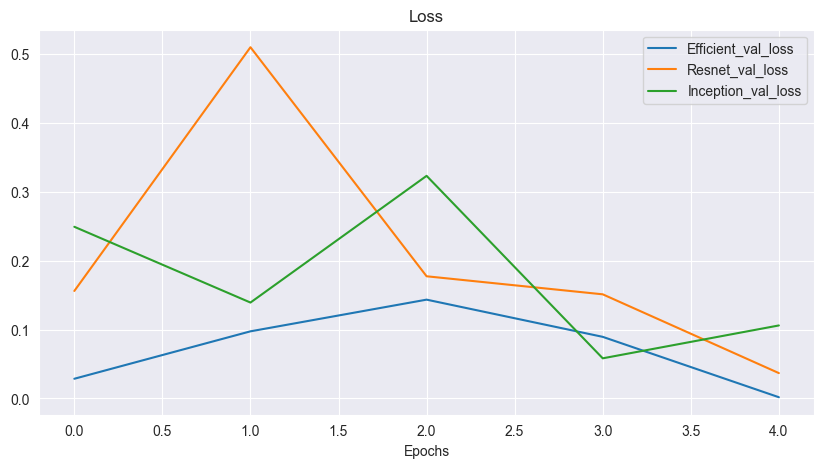

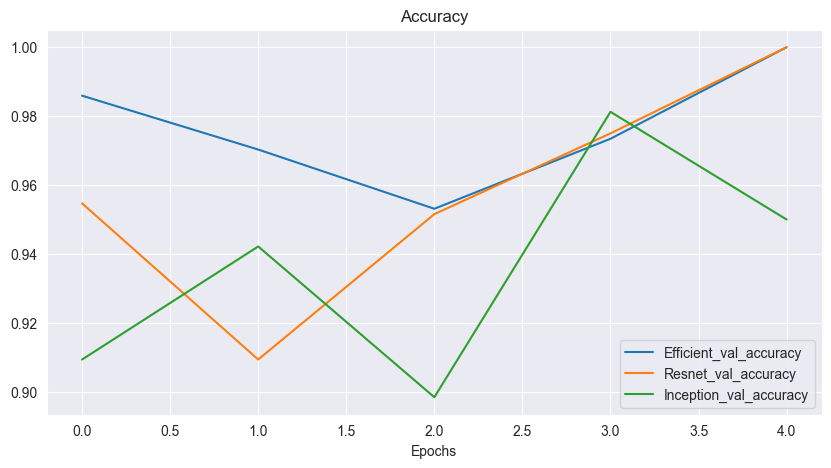

In [59]:
plot_loss_curves_multi(histories_list, labels_list, figsize=(10, 5))

#### Observation:

The DataFrame and the loss curves plot confirm that the **EfficientNetV2B3** base model show the highest accuracy and the lowest loss.<br>
Hence, I go on to fine tune the **model_0_effiicient** below.

## Model_1: Fine-tuning of Model_0 (EfficientNetV2B3)

### Callbacks

In [77]:
ealrystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=2,
                                                          restore_best_weights=True,
                                                          verbose=1)

# Setup checkpoint path
checkpoint_path = '/tmp/ckpt/checkpoint_efficient_fine.weights.h5'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         monitor='val_loss',
                                                         verbose=1)

### Building Model_1

In [62]:
# Inspect layer names, types and trainability
for layer_number, layer in enumerate(model_0_efficient.layers):
  print(f"{layer_number} | name: {layer.name} | type: {layer} | Trainable? {layer.trainable}")

0 | name: input_layer | type: <InputLayer name=input_layer, built=True> | Trainable? True
1 | name: data_augmentation | type: <Sequential name=data_augmentation, built=True> | Trainable? True
2 | name: efficientnetv2-b3 | type: <Functional name=efficientnetv2-b3, built=True> | Trainable? False
3 | name: global_max_pooling_layer | type: <GlobalMaxPooling2D name=global_max_pooling_layer, built=True> | Trainable? True
4 | name: output_layer | type: <Dense name=output_layer, built=True> | Trainable? True


In [67]:
# Unfreeze all of the layers in the base model
base_model_efficient.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model_efficient.layers[:-5]:
  layer.trainable = False

In [68]:
# Recompile model with lower learning rate
model_0_efficient.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [69]:
# What layers in the model are trainable?
for layer in model_0_efficient.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b3 True
global_max_pooling_layer True
output_layer True


In [70]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model_efficient.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_3 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv F

In [78]:
# Fine tune for longer
FINE_TUNE_EPOCHS = INITIAL_EPOCHS + 5

history_1_efficient = model_0_efficient.fit(train_data,
                        epochs=FINE_TUNE_EPOCHS,
                        validation_data=test_data,
                        initial_epoch=history_0_efficient.epoch[-1], # start from previous last epoch
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[ealrystopping_callback]
                        )

Epoch 5/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 1540s 2s/step - accuracy: 0.9633 - loss: 0.1127 - val_accuracy: 0.9609 - val_loss: 0.1093
Epoch 6/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 1491s 2s/step - accuracy: 0.9636 - loss: 0.1183 - val_accuracy: 0.9750 - val_loss: 0.0600
Epoch 7/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 1505s 2s/step - accuracy: 0.9652 - loss: 0.1121 - val_accuracy: 0.9828 - val_loss: 0.0509
Epoch 8/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 1506s 2s/step - accuracy: 0.9650 - loss: 0.1101 - val_accuracy: 0.9625 - val_loss: 0.1327
Epoch 9/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 1463s 2s/step - accuracy: 0.9670 - loss: 0.1047 - val_accuracy: 1.0000 - val_loss: 8.8346e-04
Epoch 10/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 1485s 2s/step - accuracy: 0.9650 - loss: 0.1063 - val_accuracy: 0.9750 - val_loss: 0.0670
Restoring model weights from the end of the best epoch: 9.


In [79]:
test_loss_1_efficient, test_accuracy_1_efficient = model_0_efficient.evaluate(test_data)

82/82 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9748 - loss: 0.0617


In [80]:
# Before and After fine-tuning
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [81]:
labels_list = ['Efficient_Base', 'Efficient_Fine']
histories_list = [history_0_efficient, history_1_efficient]
loss_list = [test_loss_0_efficient, test_loss_1_efficient]
accuracy_list = [test_accuracy_0_efficient, test_accuracy_1_efficient]

import pandas as pd
test_df = pd.DataFrame({"model": labels_list,
                       "loss": loss_list,
                       "accuracy": accuracy_list})

test_df.head()

,model,loss,accuracy
0,Efficient_Base,0.149827,0.959615
1,Efficient_Fine,0.065625,0.976538


5
11
[0.9398189187049866, 0.940940797328949, 0.9412612915039062, 0.9449875950813293, 0.9374148845672607, 0.9631781578063965, 0.9626973271369934, 0.964540421962738, 0.9641798138618469, 0.9661030769348145, 0.9655020236968994]


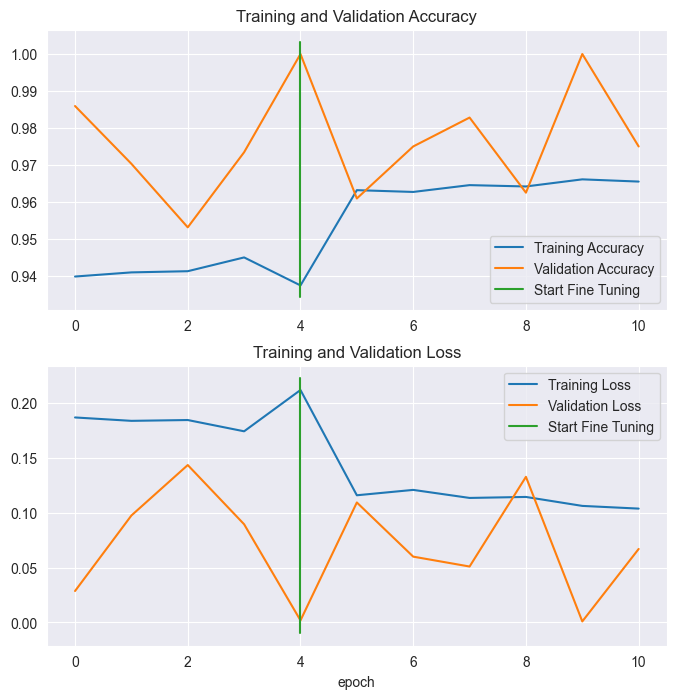

In [82]:
compare_historys(history_0_efficient, history_1_efficient, initial_epochs=5)

In [87]:
model_0_efficient.save("malaria_best_model.keras")

#### Observation:
The fine tuning has successfully improved the base model with the performance of:

Accuracy: 97.65% (base: 95.96%)<br>
Loss: 6.56% (base: 14.98%)

Accuracy increased by approximately 2% and loss was halved.
Below, we'll see how good the model is at classifying classes and whether there are any unbalanced results.

## Evaluation of Predictions

### Making Predictions

In [90]:
# Make predictions with model
pred_probs = model_0_efficient.predict(test_data, verbose=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step


In [91]:
# How many predictions are there?
len(pred_probs)

2600

In [92]:
# What's the shape of our predictions?
pred_probs.shape

(2600, 2)

In [93]:
# How do they look?
pred_probs[:10]

array([[9.9999547e-01, 4.5758607e-06],
       [9.9769300e-01, 2.3070099e-03],
       [9.6641225e-01, 3.3587754e-02],
       [9.9767607e-01, 2.3239120e-03],
       [9.9999464e-01, 5.3724762e-06],
       [2.1927334e-01, 7.8072667e-01],
       [9.9999917e-01, 8.0859445e-07],
       [6.0113776e-01, 3.9886230e-01],
       [9.9995852e-01, 4.1522671e-05],
       [6.0582638e-01, 3.9417359e-01]], dtype=float32)

In [94]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 2
What prediction probability sample 0 looks like:
 [9.9999547e-01 4.5758607e-06]
The class with the highest predicted probability by the model for sample 0: 0


In [95]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [96]:
# To get the test dataset labels we can unravel our test_data object
# (which is in the form of a tf.data.Dataset) using the unbatch() method.
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [97]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

2600

### Evaluating Predictions

In [98]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.9765384615384616

In [99]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(test_accuracy_1_efficient, sklearn_accuracy)} | Difference: {test_accuracy_1_efficient - sklearn_accuracy}")

Close? True | Difference: 1.778969394017338e-08


In [105]:
def plot_confusion_matrix(y_true, y_pred, figsize=(10, 10), class_names=None, text_size=15):

    import itertools

    try:

        # Create the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
        n_classes = cm.shape[0]

        # Let's prettify it
        fig, ax = plt.subplots(figsize=figsize)
        # Create a matrix plot
        cax = ax.matshow(cm, cmap=plt.cm.Blues)
        fig.colorbar(cax)

        # Create classes
        if class_names:
            labels = class_names
        else:
            labels = np.arange(cm.shape[0])

        # Label the axes
        ax.set(title="Confusion Matrix",
               xlabel="Predicted label",
               ylabel="True label",
               xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=labels,
               yticklabels=labels)

        # Set x-axis labels to bottom
        ax.xaxis.set_label_position("bottom")
        ax.xaxis.tick_bottom()

        # Adjust label size
        ax.xaxis.label.set_size(text_size)
        ax.yaxis.label.set_size(text_size)
        ax.title.set_size(text_size)

        # Set threshold for different colors
        threshold = (cm.max() + cm.min()) / 2.

        # Plot the text on each cell
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        ax.grid(False)
        plt.show()

    except Exception as e:
        print("An error occurred:", e)
        print("Did you change the y_pred probabilities to the same format as test_labels (y_true)?\n\nFor binary:\n y_pred_binary = (y_pred > 0.5).astype(int).flatten()\n\nFor multiclass:\ny_pred_multiclass = y_pred.argmax(axis=1)")

In [106]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['parasitized', 'uninfected']

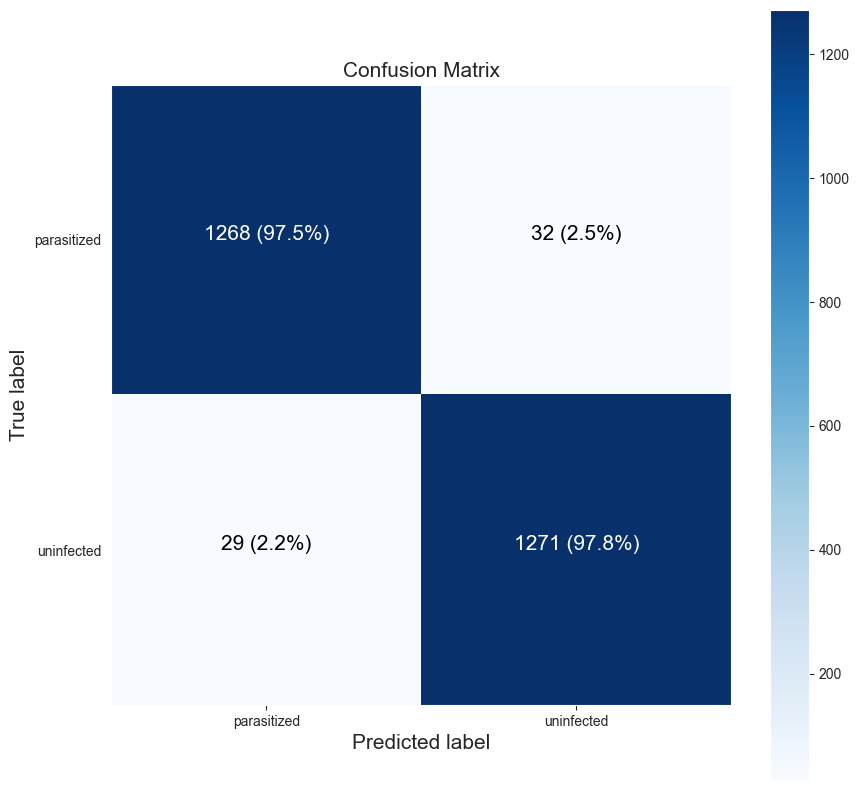

In [107]:
# Plot a confusion matrix with all predictions, ground truth labels and classes
plot_confusion_matrix(y_labels, pred_classes, figsize=(10, 10), class_names=class_names, text_size=15)

In [103]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



In [108]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.9776407093292213,
  'recall': 0.9753846153846154,
  'f1-score': 0.9765113592606854,
  'support': 1300.0},
 '1': {'precision': 0.97544128933231,
  'recall': 0.9776923076923076,
  'f1-score': 0.9765655013446024,
  'support': 1300.0},
 'accuracy': 0.9765384615384616,
 'macro avg': {'precision': 0.9765409993307657,
  'recall': 0.9765384615384616,
  'f1-score': 0.9765384303026439,
  'support': 2600.0},
 'weighted avg': {'precision': 0.9765409993307657,
  'recall': 0.9765384615384616,
  'f1-score': 0.976538430302644,
  'support': 2600.0}}

In [109]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'parasitized': 0.9765113592606854, 'uninfected': 0.9765655013446024}

In [110]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
1,uninfected,0.976566
0,parasitized,0.976511


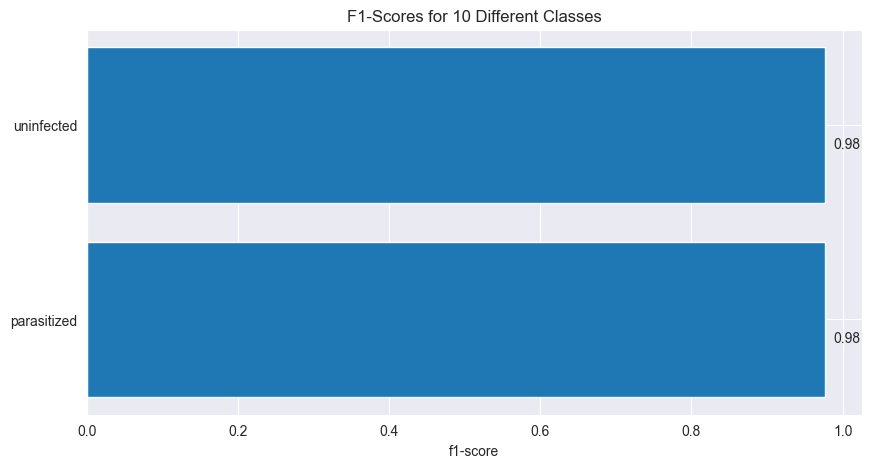

In [114]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

#### Observations:

The confusion matrix, classification report, data frame and bar chart show the strong result of the classification ability of the fine-tuned version of the base model.<br>
Precision, recall and F1 score are all around **98%**. This means that only a few (**61 test examples**) were misclassified.

### Visualizing predictions on test images

In [115]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


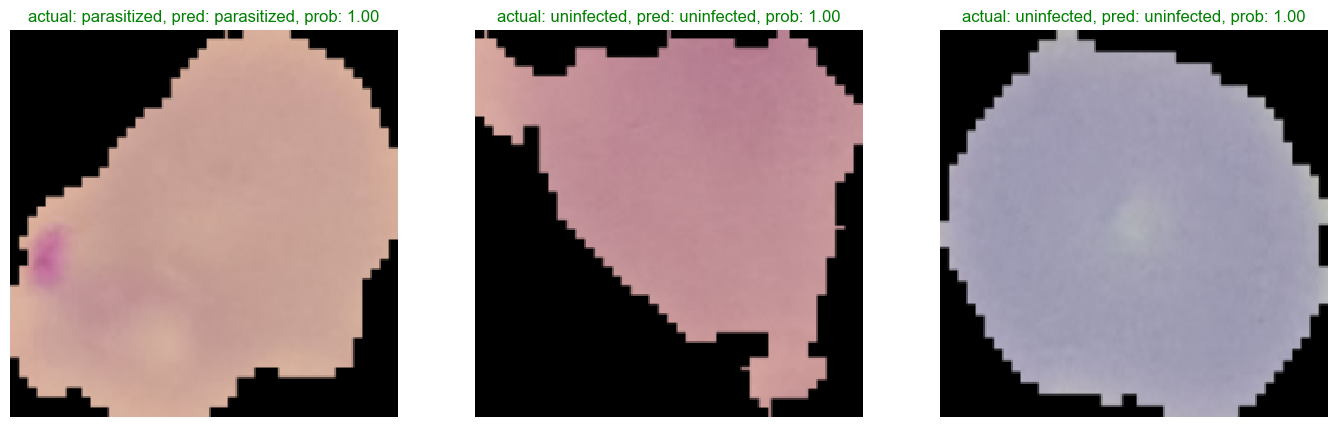

In [117]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model_0_efficient.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Finding the most wrong predictions

In [118]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("cell_images/test/*/*.png", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'cell_images\\test\\parasitized\\C39P4thinF_original_IMG_20150622_105253_cell_105.png',
 b'cell_images\\test\\parasitized\\C39P4thinF_original_IMG_20150622_105253_cell_106.png',
 b'cell_images\\test\\parasitized\\C39P4thinF_original_IMG_20150622_105253_cell_107.png',
 b'cell_images\\test\\parasitized\\C39P4thinF_original_IMG_20150622_105253_cell_108.png',
 b'cell_images\\test\\parasitized\\C39P4thinF_original_IMG_20150622_105253_cell_109.png',
 b'cell_images\\test\\parasitized\\C39P4thinF_original_IMG_20150622_105253_cell_92.png',
 b'cell_images\\test\\parasitized\\C39P4thinF_original_IMG_20150622_105253_cell_93.png',
 b'cell_images\\test\\parasitized\\C39P4thinF_original_IMG_20150622_105253_cell_94.png',
 b'cell_images\\test\\parasitized\\C39P4thinF_original_IMG_20150622_105253_cell_95.png',
 b'cell_images\\test\\parasitized\\C39P4thinF_original_IMG_20150622_105253_cell_96.png']

In [119]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'cell_images\\test\\parasitized\\C39P4thinF_o...,0,0,0.999995,parasitized,parasitized
1,b'cell_images\\test\\parasitized\\C39P4thinF_o...,0,0,0.997693,parasitized,parasitized
2,b'cell_images\\test\\parasitized\\C39P4thinF_o...,0,0,0.966412,parasitized,parasitized
3,b'cell_images\\test\\parasitized\\C39P4thinF_o...,0,0,0.997676,parasitized,parasitized
4,b'cell_images\\test\\parasitized\\C39P4thinF_o...,0,0,0.999995,parasitized,parasitized


In [120]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'cell_images\\test\\parasitized\\C39P4thinF_o...,0,0,0.999995,parasitized,parasitized,True
1,b'cell_images\\test\\parasitized\\C39P4thinF_o...,0,0,0.997693,parasitized,parasitized,True
2,b'cell_images\\test\\parasitized\\C39P4thinF_o...,0,0,0.966412,parasitized,parasitized,True
3,b'cell_images\\test\\parasitized\\C39P4thinF_o...,0,0,0.997676,parasitized,parasitized,True
4,b'cell_images\\test\\parasitized\\C39P4thinF_o...,0,0,0.999995,parasitized,parasitized,True


In [121]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
2376,b'cell_images\\test\\uninfected\\C68P29N_ThinF...,1,0,0.999995,uninfected,parasitized,False
1498,b'cell_images\\test\\uninfected\\C39P4thinF_or...,1,0,0.999726,uninfected,parasitized,False
2128,b'cell_images\\test\\uninfected\\C60P21thinF_I...,1,0,0.998818,uninfected,parasitized,False
862,b'cell_images\\test\\parasitized\\C63P24N_Thin...,0,1,0.996726,parasitized,uninfected,False
206,b'cell_images\\test\\parasitized\\C39P4thinF_o...,0,1,0.993772,parasitized,uninfected,False
1124,b'cell_images\\test\\parasitized\\C68P29N_Thin...,0,1,0.991315,parasitized,uninfected,False
994,b'cell_images\\test\\parasitized\\C68P29N_Thin...,0,1,0.989934,parasitized,uninfected,False
1047,b'cell_images\\test\\parasitized\\C68P29N_Thin...,0,1,0.988709,parasitized,uninfected,False
2337,b'cell_images\\test\\uninfected\\C68P29N_ThinF...,1,0,0.984675,uninfected,parasitized,False
2496,b'cell_images\\test\\uninfected\\C71P32_ThinF_...,1,0,0.981621,uninfected,parasitized,False


In [127]:
len(top_100_wrong)

61

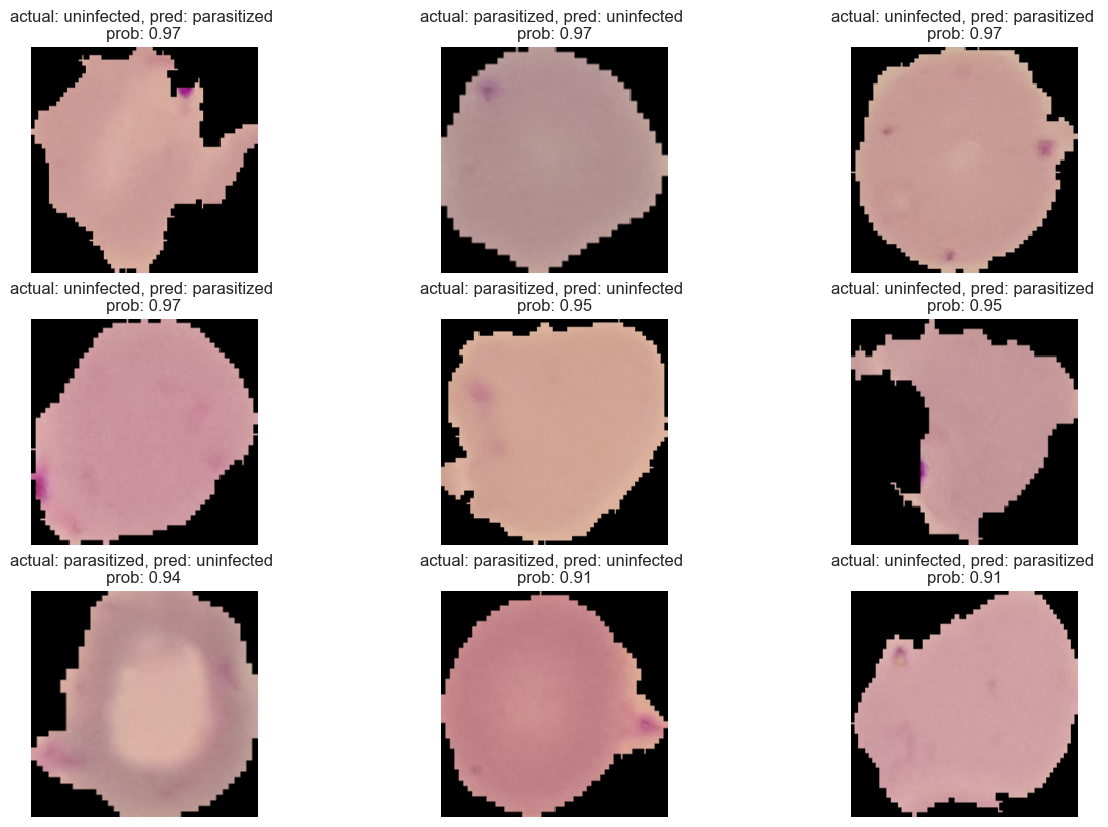

In [131]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

#### Observations:

The misclassified images confirm that they are some of the most difficult images that seem to share the characteristics of the other class.

## Executive summary:


The analysis conducted in the final milestone of our project yielded crucial insights into the development and evaluation of a deep learning model for malaria detection. After comparing three pre-trained base models, fine-tuning the best-performing model, and evaluating its predictions, we achieved a significant improvement in accuracy and performance. The final proposed model, based on EfficientNetV2B3 architecture, demonstrated an accuracy of approximately 97.65% and a notably reduced loss of 6.56%. Through comprehensive evaluation metrics such as precision, recall, and F1 score, we confirmed the model's robust classification capability, particularly in distinguishing between parasitized and uninfected red blood cells. The successful development of this model holds promising implications for improving malaria diagnosis, enabling timely intervention, and potentially saving lives.

## Problem and solution summary

**Problem Summary**:<br>
The manual diagnosis of malaria is time-consuming and prone to inter-observer variability, leading to delayed treatment and potentially severe complications for patients. With millions of cases reported annually, there is a pressing need for innovative diagnostic approaches to enhance the efficiency and accuracy of malaria detection.
<br>
<br>
**Solution Design Reasoning**:<br>
The proposed solution involves leveraging deep learning models trained on large datasets of labeled cell images to automate malaria diagnosis. By harnessing the power of deep learning, we aim to reduce diagnosis time, mitigate inter-observer variability, and improve overall diagnostic accuracy.
<br>
<br>
**Impact on Problem/Business**:<br>
Implementing this solution could significantly improve healthcare delivery by providing rapid and accurate identification of malaria parasites. This would enable timely treatment, prevent disease spread, and alleviate the socioeconomic burden associated with malaria. Furthermore, by streamlining the diagnostic process, healthcare resources can be allocated more effectively, leading to better patient outcomes and potentially reducing healthcare costs.

## Recommendations for implementation
<br>
Key Recommendations:<br>
<br>
- Deploy the final proposed model in clinical settings with expert supervision to evaluate its performance in real-world scenarios.<br>
- Collaborate with healthcare providers and regulatory authorities to ensure compliance with medical standards and obtain necessary approvals for deployment.<br>
- Develop mechanisms for continuous monitoring and maintenance of the model to address any performance degradation or emerging challenges over time.<br>
- Conduct further analysis to assess the model's generalizability across diverse populations and geographic regions to enhance its applicability.<br>
- Explore potential collaborations with research institutions or public health agencies to expand the dataset and improve the model's training and validation.
<br>
<br>
Additional Recommendations:<br>
<br>
Utilize Unseen Images:<br>
<br>
Leverage the model to analyze new, unseen images for malaria diagnosis, thereby facilitating prompt and accurate identification of infected individuals.<br>
<br>
Enhance Model Robustness:<br>
<br>
Further analyze the 61 misclassified images to identify patterns and insights that can inform adjustments to the model architecture, training data, or feature extraction methods, leading to a more robust and accurate diagnostic tool.<br>
<br>
Iterative Model Training:<br>
<br>
Train another model using additional test data, incorporating insights from domain experts to refine the model's performance and clarify the patterns associated with misclassified images. This iterative approach can contribute to continuous improvement and refinement of the diagnostic capabilities.<br>
<br>
Continuous Performance Monitoring:<br>
<br>
Establish a framework for ongoing performance monitoring of the deployed model, tracking key metrics such as accuracy, precision, and recall over time. Regular evaluations and feedback loops will enable timely adjustments and improvements to maintain optimal performance and ensure alignment with evolving diagnostic standards and practices.

<br>
[End of notebook]